In [ ]:
%%HTML
<!-- Make fonts readable at 1024x768 -->
<style>
.rendered_html { font-size:0.7em; }
</style>

In [2]:
import numpy as np
import scipy.signal
%matplotlib notebook
import matplotlib.pylab as plt
from matplotlib import animation, patches
from IPython.display import display, Audio, HTML
import soundfile as sf
from style import *

### Universidad Austral de Chile 

## INFO183: Análisis de sistemas lineales

# Unidad 4: Sistemas y filtros adaptivos

### Dr. Pablo Huijse, phuijse at inf dot uach dot cl 

### <a href="https://github.com/phuijse/UACH-INFO183"> github.com/phuijse/UACH-INFO183 </a>


***
<a id="index"></a>

# Contenidos de la unidad

***

1. [Estimador lineal óptimo](#section1)
1. [Gradiente descendente](#section2)
1. [Algoritmo de mínimos cuadrados (LMS)](#section3)
1. Algoritmo de mínimos cuadrados recursivo (RLS)

### Bibliografía
1. Simon Haykin, "Adaptive filter theory" 5ed, Pearson
1. Weifeng Liu, José Príncipe, Simon Haykin, "Kernel adaptive filtering", Wiley

# Introducción
***

- **Estimador:** Sistema diseñado para **extraer información** a partir de una **señal**
- La señal contiene **información y ruido** 
- La señal es representada como una secuencia de **datos**

Tipos de estimador
- **Filtro:** Estimo el valor actual de mi señal acentuando o eliminando una o más características
- **Predictor:** Estimo el valor futuro de mi señal

Estimador lineal óptimo
- Lineal: La cantidad estimada es una función lineal de la entrada
- Óptimo: El estimador es la mejor solución posible de acuerdo a un criterio (*e.g.* Error cuadrático medio)

Estimador lineal adaptivo
- Es lineal pero no LTI
- Sus parámetros cambian en función del tiempo
- Diseñamos una regla para actualizar sus parámetros
- Usualmente las reglas están basadas en criterios de optimización


<img src="img/adaptive-systems1.png">

## Proceso aleatorio/estocástico
***

- Colección de variables aleatorias indexadas en el tiempo
- Evolución de un fenomeno estadístico en el tiempo
- El fenomeno se rige por leyes probabilísticas


Un proceso aleatorio $U_n = (u_n, u_{n-1}, u_{n-2}, \ldots, u_{n-L})$ se describe a través de sus momentos

Si consideramos una caracterízación de segundo orden necesitamos definir
- Momento central o media 
$$
\mu(n) = \mathbb{E}[U_n]
$$
- Segundo momento o correlación
$$
r_{uu}(n, n-k) = \mathbb{E}[U_n U_{n-k}]
$$
- Segundo momento centrado o covarianza
$$
\begin{align}
c_{uu}(n, n-k) &= \mathbb{E}[(U_n-\mu_n) (U_{n-k}- \mu_{n-k})] \nonumber \\
&= r(n,n-k) - \mu_n \mu_{n-k} \nonumber
\end{align}
$$
- correlación cruzada entre dos procesos 
$$
r_{ud}(n, n-k) = \mathbb{E}[U_n D_{n-k}]
$$

***
En general consideraremos el caso simplificado donde el proceso es estacionario

$$
\mu(n)  = \mu, \forall n
$$
y
$$
r_{uu}(n, n-k)  = r_{uu}(k), \forall n
$$
es decir los estadísticos se mantienen constantes en el tiempo (no depende de $n$)

Otra simplificación es que el proceso sea ergódico

$$
\mathbb{E}[U_n] = \frac{1}{N} \sum_{n=1}^N u_n
$$

es decir podemos reemplazar el valor esperado por la media en el tiempo
***

### Densidad espectral de potencia

Otra cantidad de interés es la PSD (*power spectral density*) que mide la distribución de la potencia en frecuencia

$$
\begin{align}
S_{uu}(f) &= \sum_{k=-\infty}^{\infty} r_{uu}(k) e^{-j 2\pi f k} \nonumber \\
&= \lim_{N\to\infty} \frac{1}{2N+1} \mathbb{E} \left [\left|\sum_{n=-N}^{N} u_n e^{-j 2\pi f n} \right|^2 \right]
\end{align}
$$
que corresponde a la transformada de Fourier de la correlación (caso estacionario)

La PSD y la correlación forman un par de Fourier

[&larr; Volver al índice](#index)

***
<a id="section1"></a>

# Estimadores óptimos
***
[Óptimo](http://dle.rae.es/?id=R7bbor7): adj. Sumamente bueno, que no puede ser mejor.

Para diseñar un estimador óptimo necesitamos un **criterio**

Luego el estimador será **óptimo según dicho criterio**

Usualmente también consideramos supuestos. Podríamos asumir que
- el ruido es aditivo y blanco o que tiene una cierta covarianza conocida
- conocemos la media y covarianza de la señal
- el proceso es estacionario



## Filtro de Wiener

- Filtro LTI de tiempo discreto
- Estructura FIR con $L+1$ coeficientes: $h_0, h_1, h_2, \ldots, h_{L}$
- La entrada es una señal $u_0, u_1, u_2, \ldots$
- Para cada tiempo el filtro produce una salida $y_0, y_1, y_2, \ldots$

Adaptamos los coeficientes del filtro con dos ingredientes
- Una respuesta "deseada" $d_0, d_1, d_2, \ldots$
- Un criterio de optimalidad que opera sobre el error entre la respuesta deseada y la salida
$$
e_n = d_n - y_n = d_n - \sum_{k=0}^{L} h_k u_{n-k} 
$$

Diagrama del filtro de Wiener

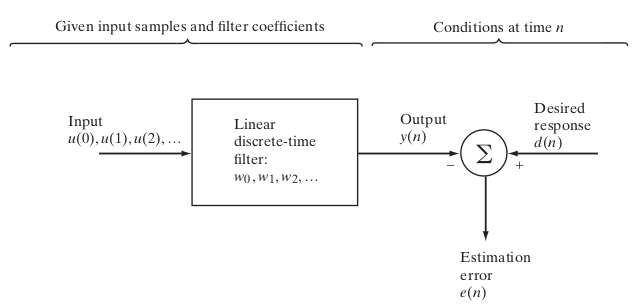

(Este filtro fue publicado por Norbert Wiener en 1949)

## Ajuste del filtro de Wiener

El criterio más común para adaptar el filtro de Wiener es **el error medio cuadrático** entre la respuesta deseada y la salida del filtro. Asumiendo que la $u$ e $d$ son secuencias reales

$$
\begin{align}
\text{MSE} &= \mathbb{E}\left [e_n^2 \right] \nonumber \\
&= \mathbb{E}\left [(d_n - y_n)^2 \right] \nonumber \\
&= \mathbb{E}\left [d_n^2 \right]  - 2\mathbb{E}\left [ d_n y_n \right] + \mathbb{E}\left [ y_n^2 \right] \nonumber 
\end{align}
$$
donde $\sigma_d^2 = \mathbb{E}\left [d_n^2 \right]$ es la varianza de la señal deseada y $\sigma_y^2 = \mathbb{E}\left [ y_n^2 \right]$ es la varianza de nuestro estimador
 
***
Minimizar el MSE implica acercar la salida del filtro a la respuesta deseada
***
En este caso igualando la derivada del MSE a cero tenemos 

$$
\begin{align}
\frac{d}{d h_j} \text{MSE} &= -2\mathbb{E}\left[ d_n \frac{d y_n}{d h_j}  \right]  + 2 \mathbb{E}\left[ y_n \frac{d y_n}{d h_j}    \right]  \nonumber \\
&= -2\mathbb{E}\left[ d_n u_{n-j} \right]  + 2 \mathbb{E}\left[ y_n u_{n-j}    \right]  \nonumber \\
&= -2\mathbb{E}\left[ d_n u_{n-j} \right]  + 2 \mathbb{E}\left[ \sum_{k=0}^{L} h_k u_{n-k}  u_{n-j} \right] \nonumber \\
&= -2\mathbb{E}\left[ d_n u_{n-j} \right]  + 2 \sum_{k=0}^{L} h_k \mathbb{E}\left[ u_{n-k}  u_{n-j} \right] = 0 \nonumber \end{align}
$$

Si despejamos y repetimos para $j=0, \ldots, L$ obtenemos el siguiente sistema de ecuaciones

$$
\begin{align}
\begin{pmatrix}
r_{uu}(0) & r_{uu}(1) & r_{uu}(2) & \ldots & r_{uu}(L) \\
r_{uu}(1) & r_{uu}(0) & r_{uu}(1) & \ldots & r_{uu}(L-1) \\
r_{uu}(2) & r_{uu}(1) & r_{uu}(0) & \ldots & r_{uu}(L-2) \\
\vdots & \vdots & \vdots & \ddots &\vdots \\
r_{uu}(L) & r_{uu}(L-1) & r_{uu}(L-2) & \ldots & r_{uu}(0) \\
\end{pmatrix}
\begin{pmatrix}
h_0  \\
h_1  \\
h_2  \\
\vdots  \\
h_L \\
\end{pmatrix} &= 
\begin{pmatrix}
r_{ud}(0)  \\
r_{ud}(1)  \\
r_{ud}(2) \\
\vdots  \\
r_{ud}(L) \\
\end{pmatrix} \nonumber \\
R_{uu} \textbf{h} &= R_{ud},
\end{align}
$$

que se conoce como las ecuaciones de Wiener-Hopf. 

Además $R_{uu}$ se conoce como matriz de auto-correlación. Asumiendo que $R_{uu}$ es no-singular, la **solución óptima en el sentido de mínimo MSE** es 

$$
\textbf{h}^{*} = R_{uu} ^{-1} R_{ud}
$$

En general $R_{uu}$ es una matriz definida-positiva (su inversa existe) y el sistema puede resolverse en $\mathcal{O}(L^2)$ usando la [recursión de Levison-Durbin](https://en.wikipedia.org/wiki/Levinson_recursion)

Requisitos/supuestos de este filtro
- la salida deseada y la entrada tienen media cero, *i.e.* $\mathbb{E}[d_n] = \mathbb{E}[u_n] = 0$ (si existe podemos restarla)
- la salida deseada y la entrada son estacionarias en el sentido amplio, *i.e.* la correlación solo depende de $m$

## Error mínimo del filtro de Wiener

Dado que $y_n = \textbf{h}^T U_n = U_n^T \textbf{h} $, podemos expresar el MSE como
$$
\begin{align}
\text{MSE} &= \mathbb{E}\left [d_n^2 \right]  - 2\mathbb{E}\left [ d_n y_n \right] + \mathbb{E}\left [ y_n^2 \right] \nonumber \\
&= \mathbb{E}\left [d_n^2 \right] - 2 \textbf{h}^T \mathbb{E}\left [ d_n U_n \right]  + \textbf{h}^T \mathbb{E}\left [U_n U_n^T \right]  \textbf{h}  \nonumber \\
&= \sigma_d^2 - 2 \textbf{h}^T R_{ud} + \textbf{h}^T R_{uu} \textbf{h} \nonumber 
\end{align}
$$

Luego el mínimo error que se puede obtener es

$$
\begin{align}
\text{MSE}_{\text{min}} &= \sigma_d^2 - (R_{uu}^{-1} R_{ud})^T R_{ud} \nonumber \\
&= \sigma_d^2 - R_{ud}^T R_{uu}^{-1} R_{ud} < \sigma_d^2
\end{align}
$$

## Filtro de wiener: Regresión (identificación de sistema)

En regresión buscamos encontrar los coeficientes $h$ a partir de $(X, Y)$ tal que
$$
Y = h^T X + \epsilon,
$$
donde $X \in \mathbb{R}^{N\times D}$ son las variables dependientes (entrada), $Y \in \mathbb{R}^N$ es la  variable dependiente (salida) y $\epsilon$ es ruido.


### Entrenamiento del predictor

- Asumimos que hemos observado N muestras de $X$ e $Y$ 
- A partir de $u=X$ construimos $R_{uu}$
- A partir de $d=Y$ construimos $R_{ud}$
- Finalmente recuperamos $\textbf{h}$ usando $R_{uu} ^{-1} R_{ud}$
- Con esto podemos interpolar $Y$ 

<IPython.core.display.Javascript object>


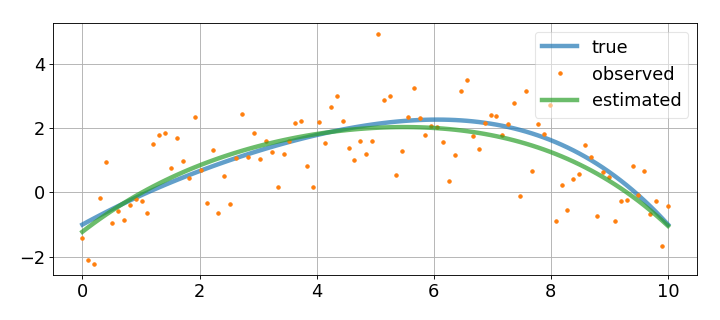

In [70]:
fig, ax = plt.subplots(1, figsize=(9, 4))
N = 100; t = np.linspace(0, 10, num=N)
U = np.ones(shape=(N, 5))
for i in range(1, 5):
    U[:, i] = t**i
h_real = [-1, 1, -0.1, 0.01, -0.001]
Y = np.dot(U, h_real) + np.random.randn(N)
Ruu = np.dot(U.T, U)
Rud = np.dot(U.T, Y[:, np.newaxis])
h = np.linalg.solve(Ruu, Rud)[:, 0]
ax.plot(t, np.dot(U, h_real), lw=4, alpha=0.7, label='true')
ax.plot(t, Y, '.', label='observed')
ax.plot(t, np.dot(U, h), lw=4, alpha=0.7, label='estimated'); plt.legend();

## Filtro de wiener: Predicción 

En este caso asumimos que la señal deseada es la entrada en el futuro
$$
d_n = \{u_{n+1}, u_{n+2}, \ldots, u_{n+m}\}
$$ 

- Donde $m$ es el horizonte de predicción
- Llamamos *predicción a un paso* al caso $m=1$
- El largo del filtro $L$ define la cantidad de muestras pasadas que usamos para predecir
- Por ejemplo un sistema de predicción a un paso con $L+1 = 3$ coeficientes:
$$
h_0 u_n +  h_1 u_{n-1} + h_2 u_{n-2}= y_n = \hat u_{n+1} \approx u_{n+1}
$$

### Entrenamiento del predictor

- Asumimos que la señal ha sido observada y que se cuenta con $N$ muestras
- Podemos formar una matriz cuyas filas son $[u_n, u_{n-1}, \ldots, u_{n-L}]$ para $n=L,L+1,\ldots, N-1$
- Podemos formar un vector $[u_N, u_{N-1}, \ldots, u_{L+1}]^T$ (caso $m=1$)
- Con esto podemos formar las matrices de correlación y obtener $\textbf{h}$
- Finalmente usamos $\textbf{h}$ para predecir el futuro no observado de $u$

¿Cómo afectan $L$ y $N$ en la calidad del predictor lineal?

<IPython.core.display.Javascript object>


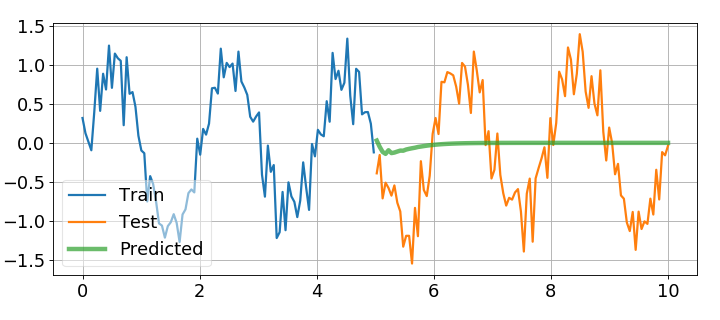

interactive(children=(SelectionSlider(continuous_update=False, description='L', index=1, layout=Layout(height=…

In [97]:
from numpy.lib.stride_tricks import as_strided
fig, ax = plt.subplots(1, figsize=(9, 4))
t = np.linspace(0, 10, num=200)
u = np.sin(2.0*np.pi*0.5*t) + 0.25*np.random.randn(len(t))
#u[150:] += 2
def update(L, N_train):    
    ax.cla();
    U = as_strided(u, [len(u)-L+1 , L+1], strides=[u.strides[0], u.strides[0]])
    Ruu = np.dot(U[:N_train, :L].T, U[:N_train, :L])
    Rud = np.dot(U[:N_train, :L].T, U[:N_train, L][:, np.newaxis])
    h = np.linalg.solve(Ruu, Rud)[:, 0]
    ax.plot(t[:N_train], u[:N_train], label='Train'); 
    ax.plot(t[N_train:], u[N_train:], label='Test'); 
    u_pred = np.zeros(shape=(len(u), ))
    u_pred[:N_train] = u[:N_train]
    for k in range(N_train, len(u)):
        u_pred[k] = np.sum(h*u_pred[k-L:k])    
    ax.plot(t[N_train:], u_pred[N_train:], linewidth=4, alpha=0.7,
            label='Predicted'); ax.legend(loc=3);

interact(update, L=SelectionSlider_nice(options=[1, 5, 10, 20, 30, 50], value=5), 
         N_train=SelectionSlider_nice(options=[len(u)//3, len(u)//2, len(u)*2//3], value=len(u)//2));

# Filtro de Wiener: Eliminar ruido blanco aditivo

En este caso asumimos que la señal de entrada corresponde a una señal deseada (información) que ha sido contaminada con ruido aditivo

$$
u_n = d_n + \nu_n,
$$

adicionalmente asumimos que
- el ruido es estacionario en el sentido amplio y de media cero $\mathbb{E}[\nu_n] = 0$
- el ruido es blanco, es decir no tiene correlación consigo mismo o con la señal deseada
$$
r_{\nu d}(k) = 0, \forall k
$$
- el ruido tiene una cierta varianza $\mathbb{E}[\nu_n^2] = \sigma_\nu^2, \forall n$

Notemos que en este caso $R_{uu} = R_{dd} + R_{\nu\nu}$ y $R_{ud} = R_{dd}$, luego

la señal recuperada es $\hat d_n = h^{*} u_n$ y el filtro es

$$
\vec h^{*} = \frac{R_{dd}}{R_{dd} + R_{\nu\nu}}
$$

y su respuesta en frecuencia

$$
H(f) = \frac{S_{dd}(f)}{S_{dd}(f) + S_{\nu\nu}(f)}
$$

es decir que 
- en frecuencias donde la $S_{dd}(f) > S_{\nu\nu}(f)$, entonces $H(f) = 1$
- en frecuencias donde la $S_{dd}(f) < S_{\nu\nu}(f)$, entonces $H(f) = 0$

# Sistemas adaptivos

Hasta ahora hemos estudiando sistemas LTI: 
- sus coeficientes quedan fijos luego del diseño y son constantes en el tiempo
- hacen supuestos sobre los estadísticos de la señal/ruido

Qué hacer si
- no podemos hacer supuestos sobre los estadísticos
- los estadísticos de la señal/ruido cambian en el tiempo (no estacionaridad)

Estimador **adaptivo**: 
- Sistemas cuyos coeficientes se pueden adaptar a medida que llegan nuevos datos
- Se diseñan de acuerdo a un método de optimización *online*



[&larr; Volver al índice](#index)

***
<a id="section2"></a>

# Gradiente descendente
***

- Sea un vector de pesos $w$ de largo $L+1$ que guarda los coeficientes de un filtro
- Sea ahora una función de costo que mapea el vector de pesos a un número real: $J(w): \mathbb{R}^{L+1} \to \mathbb{R}$
    - A menor $J$ mejor es nuestro filtro (menor error)

Para entrenar un filtro adaptivo 
1. Partimos de una solución inicial $w_0$
1. Modificamos iterativamente $w$ tal que $J(w_{t+1}) < J(w_t)$
1. Nos detenemos al cumplir un cierto criterio 

***
Una alternativa de bajo costo para lograr esto es la regla del **gradiente descendente** (GD)

$$
w_{t+1} = w_t - \mu \frac{dJ(w)}{dw},
$$

donde $\mu$ se conoce como tasa de aprendizaje o "paso"
***

- Imaginemos $J$ como una superficie de $L+1$ dimensiones
- En cada punto el gradiente negativo de $J$ nos indica hacia donde está el descenso más abrupto
- La tasa $\mu$ nos da el largo del salto entre $w_t$ y $w_{t+1}$

Notemos de la **expansión de Taylor de primer orden** de $J$ en $w_{t}$ que

$$
\begin{align}
J(w_{t+1}) &= J(w_t) + \frac{dJ(w_t)}{dw} (w_{t+1} - w_{t})  \nonumber \\
&= J(w_t) -\mu \left \| \frac{dJ(w_t)}{dw} \right \|^2 \leq J(w_t) \nonumber 
\end{align}
$$

es decir que dado usando la regla GD con $\mu>0$ se cumple que $J$ decrece monotonicamente

- Relación con método de Newton!

<IPython.core.display.Javascript object>


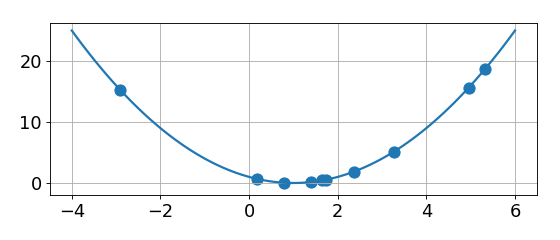

In [3]:
plt.close('all'); fig, ax = plt.subplots(1, figsize=(7, 3))
x = np.linspace(-4, 6, num=100)
L = lambda x : (x-1)**2 #+ 3*np.sin(np.pi*x)
p = 10*np.random.rand(10) - 4.
ax.plot(x, L(x))
sc = ax.scatter(p, L(p), s=100)
mu = 0.01

def update(n):
    p = sc.get_offsets()[:, 0]
    p = p - mu*2*(p-1) #- mu*3*np.pi*np.cos(np.pi*p)
    sc.set_offsets(np.c_[p, L(p)])
    
anim = animation.FuncAnimation(fig, update, frames=100, interval=200, repeat=False, blit=True)
#plt.close(); HTML(anim.to_html5_video())

## Gradiente descendente en el filtro de Wiener

Para el filtro de Wiener teniamos
$$
J(h) = \sigma_d^2 - 2 \textbf{h}^T R_{ud} + \textbf{h}^T R_{uu} \textbf{h},
$$
por ende
$$
\frac{dJ(h)}{dh} = -2 R_{ud} + 2 R_{uu} \textbf{h}
$$
y finalmente
$$
\textbf{h}_{t+1} = \textbf{h}_{t} (I - 2 \mu R_{uu}) + 2\mu R_{ud}
$$
En este caso la condición de convergencia estable es 
$$
0 < \mu < \frac{1}{\lambda_{\text{max}}},
$$
donde $\lambda_{\text{max}}$ es valor propio más grande de $R_{uu}$

Esto último viene de formar una ecuación de diferencia del estilo $\hat w_{k, t+1} = (1-\mu \lambda_k)^t \hat w_{k, t=0}$

Ref: Haykin, "Adaptive filter theory", 4.3

# Gradiente descendente estocástico (SGD)

El filtro de Wiener es óptimo pero no adaptivo
- Requiere de $N$ muestras de $u$ y $d$ para estimar $R_{ud}$ y $R_{uu}$
- Asume estacionaridad: $J(h) = \mathbb{E}\left[e_n^2\right]$
- El gradiente descendente (GD) es un método deterministico
- Los pesos se adaptan luego de haber presentado las $N$ muestras (batch)

Consideremos el caso en que los datos no son estacionarios
- Significa que debemos adaptar el filtro en cada paso a medida que nuevas muestras son observadas
- Para esto usamos la versión estocástica del GD: SGD
- Los pesos se adaptan luego de haber presentado una muestra o un conjunto pequeño (mini-batch)
- No hay garantía de llegar al óptimo en un problema convexo, pero es más eficiente computacionalmente que GD

<img src="img/adaptive-sgd.png" width="600">

[&larr; Volver al índice](#index)

***
<a id="section3"></a>
# Algoritmo Least Mean Square (LMS)
***

Podemos extender el filtro de Wiener al caso no-estacionario usando SGD
- El resultado es un algoritmo es simple (filtro FIR) que además es robusto
- A diferencia del filtro de Wiener no se requiere conocimiento estadístico del proceso
- Tampoco se requiere calcular e invertir la matriz de correlación

Consideremos la función de costo estocástica para la arquitectura FIR

$$
\begin{align}
J^s_n(\textbf{w}) &= e_n^2 \nonumber \\
&= (d_n - y_n)^2 \nonumber \\
&= (d_n - \sum_{k=0}^{L} w_{n, k} u_{n-k} )^2 \nonumber \\
\end{align}
$$
El gradiente en función del peso $w_{n, k}$ es 
$$
\frac{d J^s_n (\textbf{w})}{d w_{n, k}} = - 2 e_n u_{n-k}
$$
Usando la regla SGD llegamos a 
$$
w_{n+1, k} = w_{n, k} + 2 \mu e_n u_{n-k}, k=0, 1, \ldots, L
$$
o en forma matricial
$$
\begin{align}
\textbf{w}_{n+1} &= \textbf{w}_{n} + 2 \mu e_n \textbf{u}_{n}\nonumber \\
&= \textbf{w}_{n} + 2 \mu (d_n -  \textbf{w}_{n}^T \textbf{u}_{n}) \textbf{u}_{n}, \nonumber 
\end{align}
$$
donde $\textbf{u}_n = [u_n, u_{n-1}, \ldots, u_{n-L}]$ 

- La complejidad de este algoritmo es $2L$, el doble de la complejidad del filtro

# Interpretación geométrica del algoritmo LMS

Tenemos la siguiente regla iterativa
$$
\textbf{w}_{n+1} = \textbf{w}_{n} + 2 \mu e_n \textbf{u}_{n} = \textbf{w}_{n} + \Delta \textbf{w}_n
$$
- Los cambios en el vector de peso $\Delta \textbf{w}_n$ son paralelos a $\textbf{u}_{n}$
- Estos cambios están dominados por el $\max_k \textbf{u}_{n} = [u_n, u_{n-1}, \ldots, u_{n-L}]$

<img src="img/adaptive-lms-geometry.png" width="400px">

Figura: https://www.commsp.ee.ic.ac.uk/~mandic/SE_ASP_LN/ASP_MI_Lecture_5_Adaptive_Filters_2017.pdf

### LMS: Adaptive line enhancement (ALE)

<IPython.core.display.Javascript object>


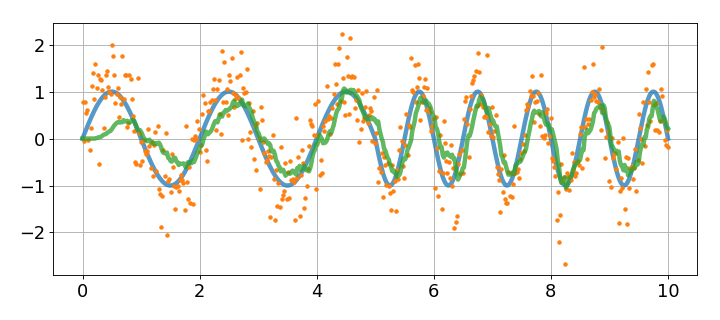

interactive(children=(SelectionSlider(continuous_update=False, description='mu', index=2, layout=Layout(height…

In [165]:
from numpy.lib.stride_tricks import as_strided
fig, ax = plt.subplots(1, figsize=(9, 4))
t = np.linspace(0, 10, num=500)
u[:250] = np.sin(2.0*np.pi*0.5*t[:250])
u[250:] = -np.sin(2.0*np.pi*1*t[250:])
u_noise = u + 0.5*np.random.randn(len(t)) 
L =  10
def update(mu):
    w = np.zeros(shape=(L, ))
    ax.cla(); ax.plot(t, u, lw=4, alpha=0.75); ax.plot(t, u_noise, '.')
    u_pred = np.zeros(shape=(len(u), ))
    for k in range(L, len(u)-1):
        u_pred[k] = np.dot(w, u_noise[k-L:k])
        w += 2*mu*(u[k] - np.dot(w, u_noise[k-L:k]))*u_noise[k-L:k]
    u_pred[k+1] = np.dot(w, u_noise[k-L+1:k+1])
    ax.plot(t, u_pred, lw=4, alpha=0.75);

interact(update, mu=SelectionSlider_nice(options=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1], value=1e-3));

### LMS: Predicción en ambiente no estacionario

<IPython.core.display.Javascript object>


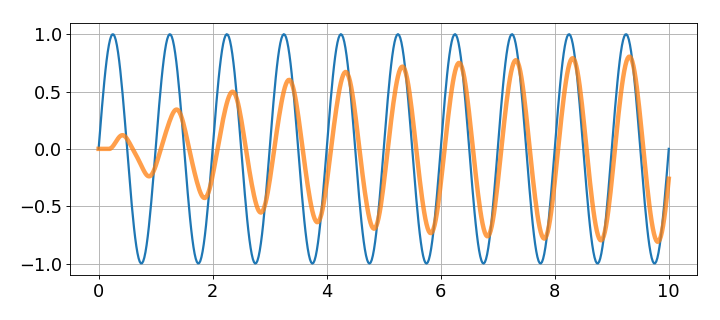

interactive(children=(SelectionSlider(continuous_update=False, description='mu', index=2, layout=Layout(height…

In [191]:
from numpy.lib.stride_tricks import as_strided
fig, ax = plt.subplots(1, figsize=(9, 4))
t = np.linspace(0, 10, num=500)
u = np.sin(2.0*np.pi*t) #+ 0.25*np.random.randn(len(t)) 
#u[200:] += 5
# u += 2*t
#u += 6*np.cos(2.0*np.pi*t/10)
def update(mu, L):
    print(1/(3*L*np.var(u)))
    w = np.zeros(shape=(L, ))
    ax.cla(); ax.plot(t, u)
    u_pred = np.zeros(shape=(len(u), ))
    for k in range(L, len(u)):
        norm = 1 #np.sum(u[k-L:k]**2)
        u_pred[k] = np.dot(w, u[k-L:k])#/norm
        w += 2*mu*(u[k] - np.dot(w, u[k-L:k]))*u[k-L:k]/norm
    ax.plot(t, u_pred, lw=4, alpha=0.75);

interact(update, mu=SelectionSlider_nice(options=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0], value=1e-3),
         L=SelectionSlider_nice(options=[1, 5, 10, 20], value=10));

- El algoritmo LMS es un sistema de control con retroalimentación
- Notemos la desestabilidad que ocurre al usar valores "inapropiados" de $\mu$
- La convergencia del algoritmo depende de $\mu$
- Cuando $\mu$ es pequeño se obtiene un comportamiento "pasa bajos"

Comparación entre Filtro de Wiener/GS y algoritmo LMS/SGD
- En el primer caso estamos en un ambiente estacionario lo cual nos permite calcular $R_{uu}$ y $R_{ud}$
- En el segundo caso el aprendizaje viene promediando a nivel de los estimadores de $w$

<img src="img/adaptive-lms.png">


Convergencia del algoritmo LMS (Haykin 6.5)
- El algoritmo LMS tiende en la media $\mathbb{E}[\textbf{w}_n] \to \textbf{w}^*$ para $n\to \infty$
- Convergencia en la media cuadrada: La varianza de $\textbf{w}_n - \textbf{w}^*$ tiene al valor mínimo de $J$ para $n\to \infty$
- Siempre que $0<\mu < \frac{1}{L \sigma_{uu}^2} < \frac{1}{\lambda_{\text{max}}}$ donde $\sigma_{uu}^2$ es la potencia de la señal
- Conviene entonces normalizar por la varianza de la señal
- Esto resulta en el algoritmo NLMS (normalized LMS)

$$
\textbf{w}_{n+1} = \textbf{w}_{n} + 2 \mu e_n \frac{\textbf{u}_{n}}{\|\textbf{u}_{n}\|^2}
$$



# Filtros adaptivos no-lineales 

- Los filtros lineales son sencillos (baja capacidad)
- Hasta ahora hemos asumido que la salida deseada y la entrada se relacionan linealmente
- Si esto no se cumple el desempeño del filtro sería subóptimo

<IPython.core.display.Javascript object>


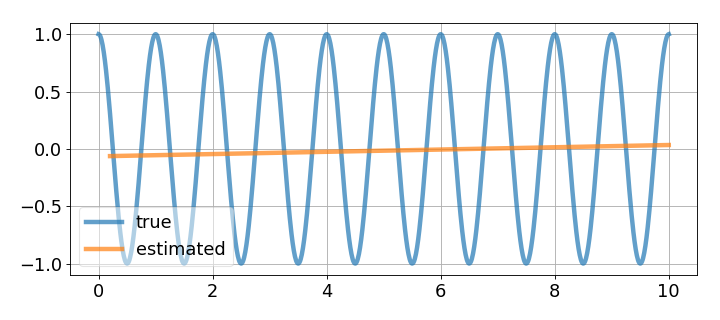

In [232]:
from numpy.lib.stride_tricks import as_strided
fig, ax = plt.subplots(1, figsize=(9, 4))
N = 1000;  L=20
u = np.linspace(0, 10, num=N)
U = as_strided(u, [len(u)-L , L], strides=[u.strides[0], u.strides[0]])
d = np.cos(2*np.pi*u)
Ruu = np.dot(U[:, :L].T, U[:, :L])
Rud = np.dot(U[:, :L].T, d[L:, np.newaxis])
h = np.linalg.solve(Ruu, Rud)[:, 0]
ax.plot(u, d, lw=4, alpha=0.7, label='true')
ax.plot(u[L:], np.dot(U, h), lw=4, alpha=0.7, label='estimated'); plt.legend();

- Para solucionar esto necesitamos aprender una transformación no-lineal para los datos
- Dos maneras de lograr esto 
    - Filtros no-lineales de topología fija: Redes neuronales
    - Método no-paramétrico: **Kernels**

## Kernels

- Los filtros basados en kernels operan en un espacio de hilbert con kernel reproductor (RKHS)
- **Espacio de Hilbert:** Espacio infinito de funciones con producto interno (producto punto)

$$
\langle f, g \rangle = \int_{-\infty}^\infty f(x) g(x) dx < \infty
$$

donde $f, g \in H$ son funciones de $\mathbb{R}^N \to \mathbb{R}$s donde $x\in \mathbb{R}^N$
- **Propiedad reproductora:** Existe un elemento de $H$ llamado $\varphi(x)$ tal que

$$
f(x) = \langle f, \varphi(x)  \rangle \quad \forall f \in H
$$

y entonces

$$
\kappa(x, y) = \langle \varphi(x), \varphi(y)  \rangle
$$

se conoce como el kernel reproductor de H $\kappa(x, y): \mathbb{R}^N \times \mathbb{R}^N \to \mathbb{R}$ y es simétrico y semidefinido positivo

Esta última igualdad se conoce como **truco del kernel**

***
Usando el truco del kernel podemos convertir un algoritmo lineal a no-lineal reeplazando un producto escalar por un kernel
***

Recuerden que teniamos

$$
y_n = \sum_{k=0}^{L} w_k u_{n-k} = \textbf{w}^T U_n = \langle \textbf{w}, U_n \rangle
$$


https://www.u-cursos.cl/ingenieria/2017/2/EL4106/1/material_docente/


http://www.cnel.ufl.edu/news/invited_talks/principe2011_asilomar.pdf

http://www1.ece.neu.edu/~erdogmus/publications/J043_SPM_ITLreview.pdf

http://www.cs.tut.fi/~tabus/course/ASP/LectureNew10.pdf

https://share.cocalc.com/share/7557a5ac1c870f1ec8f01271959b16b49df9d087/Kalman-and-Bayesian-Filters-in-Python/14-Adaptive-Filtering.ipynb?viewer=share

https://www.eit.lth.se/fileadmin/eit/courses/ett042/CE/CE5e.pdf

http://www.ee.cityu.edu.hk/~hcso/it6303_4.pdf

https://www.sparkfun.com/news/2208

http://blog.audio-tk.com/2017/03/28/audio-toolkit-recursive-least-square-filter-adaptive-module/

https://www.dummies.com/education/science/science-engineering/analysis-and-design-of-the-fir-and-iir-notch-filters/

https://stackoverflow.com/questions/35565540/designing-an-fir-notch-filter-with-python

http://www.cs.tut.fi/~tabus/course/ASP/Lectures_ASP.html

https://www.commsp.ee.ic.ac.uk/~mandic/LMS_Kalman_IEEE_SPM_2015.pdf

homes.esat.kuleuven.be/~tvanwate/courses/.../DSP2_slides_04_adaptievefiltering.pdf

https://pdfs.semanticscholar.org/aa48/98919244e59159bd276109b10dfbaa5dedf1.pdf

https://wwwmpa.mpa-garching.mpg.de/~ensslin/lectures/Files/Wiener_Filter_Demo_NIFTy3.html




    Modelado de señales
    Algoritmo Least Mean Squares (LMS)
    Cancelación de ruido y eco, Ecualización adaptiva
    Algoritmo Recursive Least Squares (RLS)
    Filtro de Kalman
    
    https://scipy-cookbook.readthedocs.io/items/KalmanFiltering.html
    
    
    Algoritmos KLMS y KRLS
